In [1]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

!date
!whoami
!pwd

Mon Sep 29 14:43:09 PDT 2025
ndbs
/mnt/share/code/ndbs/vivarium_research_alzheimers/verification_and_validation


## V&V List from Docs 

    - Verify that all simulants in the model have AD (i.e., all recorded person-time is in one of the “AD” states, not the “susceptible” state)
    - Verify that there are simulant person-years of BBBM-AD, MCI-AD, and AD-dementia for every year and age group of simulation
    - Verify that there are transitions between AD states are at the expected rates
    - Verify other sim mortality against artifact (ACMR - CSMR)
    - Verify Alzheimer’s EMR against artifact
    - Verify the number of new AD-demential cases per year against the AD population model

# Load Data

In [2]:
%cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


In [3]:
locations = ['united_states_of_america',
#              'china',
#              'brazil',
#              'japan',
#              'sweden',
#              'united_kingdom',
            ]



results_dirs = [
    'results/model4.5/united_states_of_america/2025_09_18_14_18_56/results/',
]

artifact_dirs = ['artifacts/model4.5/' + x + '.hdf' for x in locations]
artifact_dirs

['artifacts/model4.5/united_states_of_america.hdf']

In [4]:
[x for x in os.listdir(results_dirs[0]) if 'parquet' in x]

['deaths.parquet',
 'ylls.parquet',
 'new_simulants.parquet',
 'transition_count_alzheimers_disease_and_other_dementias.parquet',
 'ylds.parquet',
 'person_time_alzheimers_disease_and_other_dementias.parquet']

In [5]:
age_group_ids = [11,12,13,14,15,16,17,18,19,20,30,31,32,33]
art = Artifact(artifact_dirs[0],
               filter_terms = ['year_start==2021']  # FIXME: make this work even without filter_terms
              )

age_dictionary = pd.DataFrame()
age_dictionary['age_group_id'] = age_group_ids
age_dictionary = age_dictionary.merge(get_ids('age_group'), on='age_group_id')
age_dictionary['age_group'] = age_dictionary.age_group_name.str.lower().str.replace(' ', '_')
artifact = art.load('population.structure').reset_index()
artifact = artifact.loc[artifact.age_start > 29].reset_index()
age_dictionary['age_start'] = artifact.age_start
age_dictionary['age_end'] = artifact.age_end

# tweak final row to be named age group 95_plus
assert age_dictionary.loc[13, 'age_group'] == '95_to_99'
age_dictionary.loc[13, 'age_group'] = '95_plus'

age_dictionary.tail()

,age_group_id,age_group_name,age_group,age_start,age_end
9,20,75 to 79,75_to_79,75.0,80.0
10,30,80 to 84,80_to_84,80.0,85.0
11,31,85 to 89,85_to_89,85.0,90.0
12,32,90 to 94,90_to_94,90.0,95.0
13,33,95 to 99,95_plus,95.0,125.0


# Define a function to load simulation output

In [6]:
def load_df(measure):
    data = pd.DataFrame()
    for results_dir in results_dirs:
        temp = pd.read_parquet(results_dir + measure + '.parquet')
        
        # aggregate by summing value column over random seeds
        cols = [c for c in temp.columns if c not in ['value', 'random_seed']]
        temp = temp.groupby(cols)['value'].sum().reset_index()
        
        temp['location'] = locations[results_dirs.index(results_dir)].title()
        temp['current_year'] = temp['current_year'].astype(int)
        data = pd.concat([data, temp], ignore_index=True)
    return data

## Verify that all simulants in the model have AD 

In [7]:
person_time = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum()

0.0

In [8]:
assert person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero years of person-time susceptible'

# Verify that there *are* simulants in BBBM-AD and MCI-AD for all ages and years

In [9]:
person_time.groupby('sub_entity').value.sum()

sub_entity
alzheimers_blood_based_biomarker_state        1.219730e+08
alzheimers_disease_state                      1.642113e+08
alzheimers_mild_cognitive_impairment_state    6.475675e+07
Name: value, dtype: float64

In [10]:
person_time.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack()

sub_entity                                       alzheimers_blood_based_biomarker_state  \
location                 current_year age_group                                           
United_States_Of_America 2025         25_to_29                                 4.008214   
                                      30_to_34                              4050.800821   
                                      35_to_39                              4441.100616   
                                      40_to_44                              4251.712526   
                                      45_to_49                             13680.032854   
...                                                                                 ...   
                         2100         75_to_79                            309250.209446   
                                      80_to_84                            335033.043121   
                                      85_to_89                            285678.406571   
                                      90_to_94                            139687.745380   
                                      95_plus                              37576.501027   

sub_entity                                       alzheimers_disease_state  \
location                 current_year age_group                             
United_States_Of_America 2025         25_to_29                   0.000000   
                                      30_to_34                 160.328542   
                                      35_to_39                 177.864476   
                                      40_to_44                 155.819302   
                                      45_to_49                 562.151951   
...                                                                   ...   
                         2100         75_to_79              388816.254620   
                                      80_to_84              515163.663244   
                                      85_to_89              518445.388090   
                                      90_to_94              315001.995893   
                                      95_plus               109567.523614   

sub_entity                                       alzheimers_mild_cognitive_impairment_state  
location                 current_year age_group                                              
United_States_Of_America 2025         25_to_29                                     2.505133  
                                      30_to_34                                  2371.860370  
                                      35_to_39                                  2639.909651  
                                      40_to_44                                  2553.232033  
                                      45_to_49                                  8012.418891  
...                                                                                     ...  
                         2100         75_to_79                                162040.550308  
                                      80_to_84                                177337.897331  
                                      85_to_89                                152845.708419  
                                      90_to_94                                 75208.616016  
                                      95_plus                                  22458.020534  

[1140 rows x 3 columns]

In [16]:
temp = person_time.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum()#.unstack().fillna(0)
temp.loc[temp == 0]

location                  current_year  age_group  sub_entity              
United_States_Of_America  2025          25_to_29   alzheimers_disease_state    0.0
Name: value, dtype: float64

In [ ]:
# # This fails because of the single 0.0 above
# assert np.all(person_time.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack().fillna(0) > 0)

## Verify that there are no transitions out of susceptible state during the simulation 

In [18]:
trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum()

0.0

In [ ]:
# The dataframe is empty because we no longer have a 'susceptible' state
# in the cause model
trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias']

,measure,entity_type,entity,sub_entity,age_group,current_year,sex,scenario,input_draw,value,location


In [19]:
assert trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero transitions from susceptible to with-condition'

# And that there *are* transitions out of other states for all ages

In [ ]:
# NOTE: It seems contradictory that there are 2 MCI->AD transitions in
# the 25-29 age group in 2025, but according to the dataframe above,
# there is 0 person-time in AD in the 25-29 age group in 2025...
temp = trans.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum()
temp.unstack()

sub_entity                                       alzheimers_blood_based_biomarker_state_to_alzheimers_mild_cognitive_impairment_state  \
location                 current_year age_group                                                                                         
United_States_Of_America 2025         25_to_29                                                 0.0                                      
                                      30_to_34                                               262.0                                      
                                      35_to_39                                               362.0                                      
                                      40_to_44                                               314.0                                      
                                      45_to_49                                               889.0                                      
...                                                                                            ...                                      
                         2100         75_to_79                                             24011.0                                      
                                      80_to_84                                             27501.0                                      
                                      85_to_89                                             24024.0                                      
                                      90_to_94                                             13270.0                                      
                                      95_plus                                               4101.0                                      

sub_entity                                       alzheimers_mild_cognitive_impairment_state_to_alzheimers_disease_state  
location                 current_year age_group                                                                          
United_States_Of_America 2025         25_to_29                                                 2.0                       
                                      30_to_34                                               577.0                       
                                      35_to_39                                               688.0                       
                                      40_to_44                                               655.0                       
                                      45_to_49                                              1928.0                       
...                                                                                            ...                       
                         2100         75_to_79                                             40174.0                       
                                      80_to_84                                             44905.0                       
                                      85_to_89                                             38975.0                       
                                      90_to_94                                             20528.0                       
                                      95_plus                                               5925.0                       

[1140 rows x 2 columns]

In [133]:
temp.loc[temp==0]

location                  current_year  age_group  sub_entity                                                                          
United_States_Of_America  2025          25_to_29   alzheimers_blood_based_biomarker_state_to_alzheimers_mild_cognitive_impairment_state    0.0
                          2026          25_to_29   alzheimers_mild_cognitive_impairment_state_to_alzheimers_disease_state                  0.0
                          2027          25_to_29   alzheimers_blood_based_biomarker_state_to_alzheimers_mild_cognitive_impairment_state    0.0
                          2033          25_to_29   alzheimers_blood_based_biomarker_state_to_alzheimers_mild_cognitive_impairment_state    0.0
                          2034          25_to_29   alzheimers_blood_based_biomarker_state_to_alzheimers_mild_cognitive_impairment_state    0.0
                          2036          25_to_29   alzheimers_mild_cognitive_impairment_state_to_alzheimers_disease_state                  0.0
      

In [134]:
# # Fails because of the 0's in the 25-29 age group
# assert np.all(trans.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack() > 0)

## Next look at the transition rates and approximate durations for BBBM and MCI

In [20]:
out_counts = trans.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack()
out_counts.columns = [c.split('_to_')[0] for c in out_counts.columns]
out_counts

alzheimers_blood_based_biomarker_state  \
location                 current_year age_group                                           
United_States_Of_America 2025         25_to_29                                      0.0   
                                      30_to_34                                    262.0   
                                      35_to_39                                    362.0   
                                      40_to_44                                    314.0   
                                      45_to_49                                    889.0   
...                                                                                 ...   
                         2100         75_to_79                                  24011.0   
                                      80_to_84                                  27501.0   
                                      85_to_89                                  24024.0   
                                      90_to_94                                  13270.0   
                                      95_plus                                    4101.0   

                                                 alzheimers_mild_cognitive_impairment_state  
location                 current_year age_group                                              
United_States_Of_America 2025         25_to_29                                          2.0  
                                      30_to_34                                        577.0  
                                      35_to_39                                        688.0  
                                      40_to_44                                        655.0  
                                      45_to_49                                       1928.0  
...                                                                                     ...  
                         2100         75_to_79                                      40174.0  
                                      80_to_84                                      44905.0  
                                      85_to_89                                      38975.0  
                                      90_to_94                                      20528.0  
                                      95_plus                                        5925.0  

[1140 rows x 2 columns]

In [21]:
out_rates = out_counts / person_time.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack()
out_rates['alzheimers_blood_based_biomarker_state'].unstack()

age_group                              25_to_29  30_to_34  35_to_39  40_to_44  \
location                 current_year                                           
United_States_Of_America 2025          0.000000  0.064679  0.081511  0.073853   
                         2026          0.142564  0.065836  0.075734  0.069160   
                         2027          0.000000  0.060115  0.072308  0.071672   
                         2028          0.034412  0.060605  0.077415  0.070864   
                         2029          0.122825  0.040633  0.076140  0.071686   
...                                         ...       ...       ...       ...   
                         2096          0.101487  0.068929  0.067267  0.070487   
                         2097          0.095043  0.062043  0.066656  0.072073   
                         2098          0.127398  0.056881  0.061391  0.070017   
                         2099          0.078271  0.056364  0.067511  0.066807   
                         2100          0.063362  0.057823  0.061446  0.071687   

age_group                              45_to_49  50_to_54  55_to_59  60_to_64  \
location                 current_year                                           
United_States_Of_America 2025          0.064985  0.067228  0.070378  0.068784   
                         2026          0.069314  0.071314  0.072827  0.069723   
                         2027          0.070278  0.074284  0.073977  0.071017   
                         2028          0.069421  0.073022  0.071848  0.071435   
                         2029          0.066973  0.076421  0.075549  0.073175   
...                                         ...       ...       ...       ...   
                         2096          0.074619  0.076910  0.075074  0.073965   
                         2097          0.075851  0.078283  0.076006  0.076305   
                         2098          0.074003  0.077073  0.076893  0.074875   
                         2099          0.074041  0.079162  0.073395  0.073595   
                         2100          0.074628  0.075420  0.076260  0.074391   

age_group                              65_to_69  70_to_74  75_to_79  80_to_84  \
location                 current_year                                           
United_States_Of_America 2025          0.070146  0.070409  0.071035  0.073349   
                         2026          0.070973  0.070716  0.073421  0.077805   
                         2027          0.071109  0.072763  0.074636  0.079828   
                         2028          0.071539  0.072455  0.076019  0.080248   
                         2029          0.071430  0.073772  0.076787  0.080611   
...                                         ...       ...       ...       ...   
                         2096          0.074068  0.073230  0.077502  0.081898   
                         2097          0.073656  0.075494  0.077945  0.081511   
                         2098          0.074440  0.074299  0.077609  0.081484   
                         2099          0.073626  0.074179  0.077922  0.081830   
                         2100          0.074178  0.074438  0.077643  0.082084   

age_group                              85_to_89  90_to_94   95_plus  
location                 current_year                                
United_States_Of_America 2025          0.074354  0.073547  0.121669  
                         2026          0.078015  0.081932  0.095633  
                         2027          0.080208  0.086279  0.092097  
                         2028          0.081708  0.091320  0.093281  
                         2029          0.082501  0.092108  0.095145  
...                                         ...       ...       ...  
                         2096          0.083487  0.095346  0.110359  
                         2097          0.083626  0.094600  0.111029  
                         2098          0.084154  0.096559  0.110478  
                         2099          0.083579  0.096667  0.109498 

In [22]:
1/3.85

0.2597402597402597

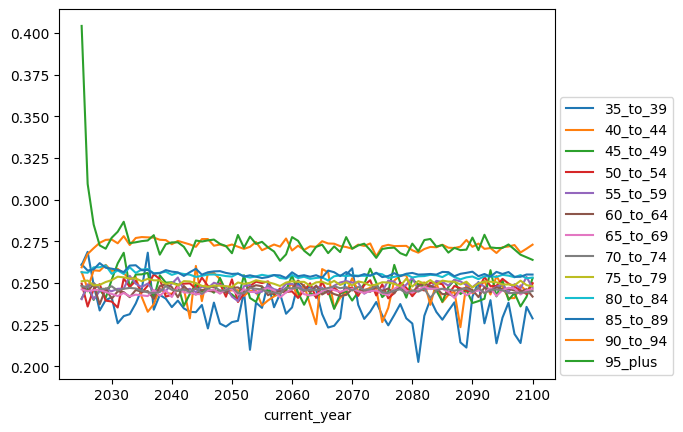

In [23]:
t = out_rates['alzheimers_mild_cognitive_impairment_state'].unstack()
t.loc['United_States_Of_America'].iloc[:,2:].plot()
plt.legend(loc=(1.01, .01));

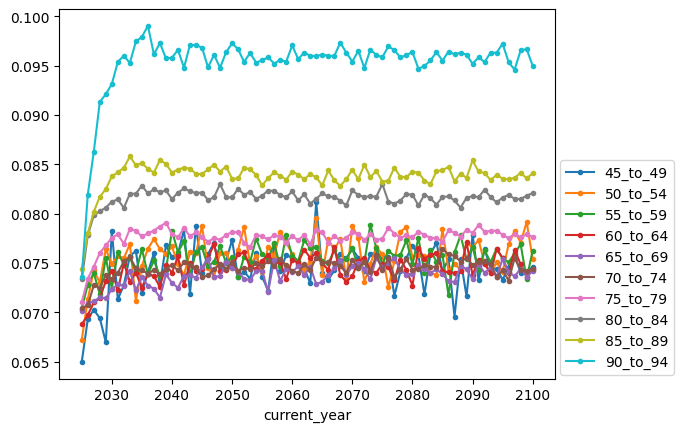

In [24]:
t = out_rates['alzheimers_blood_based_biomarker_state'].unstack()
t.loc['United_States_Of_America'].iloc[:,4:14].plot(marker='.')
plt.legend(loc=(1.01, .01));

In [25]:
# prevalence \approx incidence * duration
prevalence_count = person_time.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack()

mci_duration_est = (
    prevalence_count['alzheimers_mild_cognitive_impairment_state']
    / out_counts['alzheimers_blood_based_biomarker_state']
)
mci_duration_est

location                  current_year  age_group
United_States_Of_America  2025          25_to_29          inf
                                        30_to_34     9.052902
                                        35_to_39     7.292568
                                        40_to_44     8.131312
                                        45_to_49     9.012845
                                                       ...   
                          2100          75_to_79     6.748596
                                        80_to_84     6.448416
                                        85_to_89     6.362209
                                        90_to_94     5.667567
                                        95_plus      5.476230
Length: 1140, dtype: float64

In [26]:
new_sims = load_df('new_simulants').groupby(['location', 'current_year', 'age_group', ]).value.sum()
# new_sims


bbbm_duration_est = (
    prevalence_count['alzheimers_blood_based_biomarker_state']
    / new_sims
)
bbbm_duration_est

location                  current_year  age_group
United_States_Of_America  2025          25_to_29     0.210959
                                        30_to_34     6.877421
                                        35_to_39     2.445540
                                        40_to_44     1.598989
                                        45_to_49     3.478269
                                                       ...   
                          2100          75_to_79     3.625825
                                        80_to_84     4.126124
                                        85_to_89     3.884350
                                        90_to_94          inf
                                        95_plus           inf
Length: 1140, dtype: float64

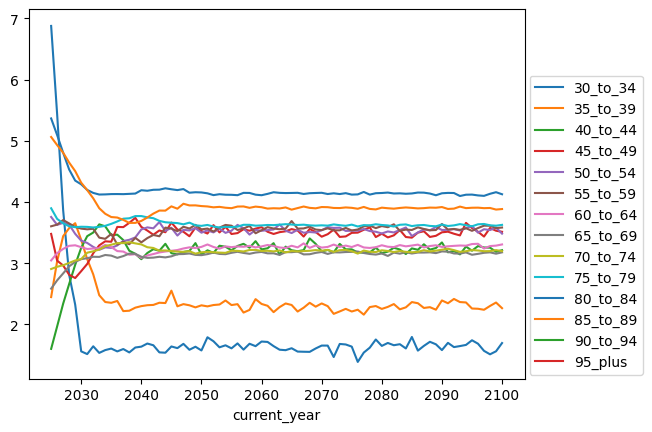

In [27]:
t = bbbm_duration_est.unstack()
t.loc['United_States_Of_America'].iloc[:, 1:].plot()
plt.legend(loc=(1.01, .01));

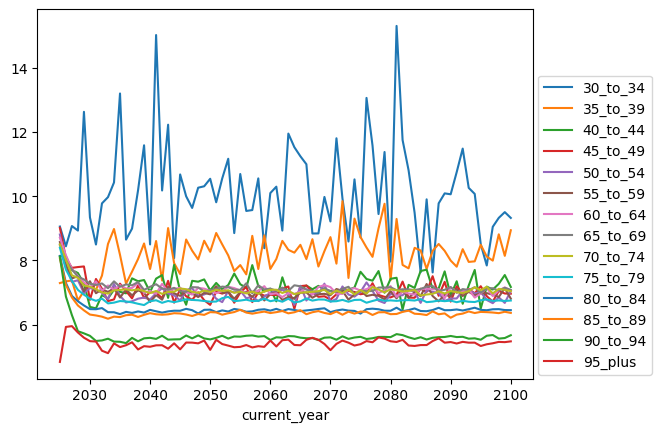

In [28]:
t = mci_duration_est.unstack()
t.loc['United_States_Of_America'].iloc[:, 1:].plot()
plt.legend(loc=(1.01, .01));

## Verify Other Cause Mortality in  Sim against artifact (ACMR - CSMR)

In [29]:
%%time

cols = ['input_draw','current_year','location','age_group','sex']

def calculate_ocmr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    total_pt = person_time_total.groupby(cols).sum(numeric_only=True)

    deaths = load_df('deaths')
    other_deaths = deaths[deaths.sub_entity == 'other_causes'].groupby(cols).sum(numeric_only=True)

    ocmr = (other_deaths / total_pt)[['value']].reset_index()

    ocmr2 = ocmr.merge(age_dictionary, on=['age_group'])
    ocmr3 = ocmr2.loc[ocmr2['age_group_id'].isin(age_group_ids)]
    ocmr4 = ocmr2.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return ocmr4

sim_ocmr = calculate_ocmr()

CPU times: user 16.8 s, sys: 191 ms, total: 17 s
Wall time: 16.6 s


In [30]:
art_ocmr = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    
    # TODO: consider better ways to broadcast years from excess mx
    a = art.load(f'cause.all_causes.cause_specific_mortality_rate')
    b = art.load(f'cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate')

    data1 = (a - b.droplevel(['year_start', 'year_end'])).dropna()
    data2 = (data1.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
            .filter(['mean', '2.5%', '97.5%']).reset_index())
    data3 = data2.merge(age_dictionary, on=['age_start','age_end'])
    data4 = data3.loc[data3['age_group_id'].isin(age_group_ids)]
    data4['measure'] = 'acmr'
    data4['location'] = locations[artifact_dirs.index(artifact_dir)].title()
    art_ocmr = pd.concat([art_ocmr, data4])
art_ocmr

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,age_group_id,age_group_name,age_group,measure,location
0,Female,30.0,35.0,2022,2023,0.000931,0.000911,0.000951,11,30 to 34,30_to_34,acmr,United_States_Of_America
1,Female,30.0,35.0,2023,2024,0.000898,0.000875,0.000925,11,30 to 34,30_to_34,acmr,United_States_Of_America
2,Female,30.0,35.0,2024,2025,0.000900,0.000871,0.000935,11,30 to 34,30_to_34,acmr,United_States_Of_America
3,Female,30.0,35.0,2025,2026,0.000901,0.000865,0.000942,11,30 to 34,30_to_34,acmr,United_States_Of_America
4,Female,30.0,35.0,2026,2027,0.000902,0.000856,0.000950,11,30 to 34,30_to_34,acmr,United_States_Of_America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,Male,95.0,125.0,2046,2047,0.255483,0.183408,0.309304,33,95 to 99,95_plus,acmr,United_States_Of_America
808,Male,95.0,125.0,2047,2048,0.255328,0.183463,0.309327,33,95 to 99,95_plus,acmr,United_States_Of_America
809,Male,95.0,125.0,2048,2049,0.255440,0.183938,0.309749,33,95 to 99,95_plus,acmr,United_States_Of_America
810,Male,95.0,125.0,2049,2050,0.255137,0.183684,0.310288,33,95 to 99,95_plus,acmr,United_States_Of_America


In [31]:
art_data = art_ocmr
location = 'United_States_Of_America'
sex='Female'
year=2030
# art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]

In [32]:
def age_group_plot(measure, sim_data, art_data, art_year=None):
    for location in sim_data.location.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
        for i, year in enumerate([2030,2040,2050]):
            for j, sex in enumerate(sim_data.sex.unique()):
                color = f'C{j}'
                plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.current_year == year) & (sim_data.sex == sex)]
                if art_year is None:
                    art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]
                else:
                    art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == art_year)]

                ax[i].fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2, color=color)
                ax[i].fill_between(art_plot.age_start, art_plot['2.5%'], art_plot['97.5%'], alpha=0.2, color=color)

                ax[i].plot(art_plot.age_start, art_plot['mean'], linestyle='--', label=f'Artifact {sex}', color=color, linewidth=3)
                ax[i].plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}', color=color)

                if i == 0:
                    ax[i].set_title(f"{measure} in {location}")

                ax[i].text(.5, .95, f"{year}", va='top', ha='center', transform=ax[i].transAxes)
#                 ax[i].tick_params(axis='x', labelrotation=90)
                
                if i == 2:
                    ax[i].set_xlabel("Age Group")
                    
                if i == 1:
                    ax[i].set_ylabel(f"{measure}")
                    ax[i].legend(loc=(1.01, 0))
#                 ax[i].semilogy()
        plt.subplots_adjust(hspace=0)


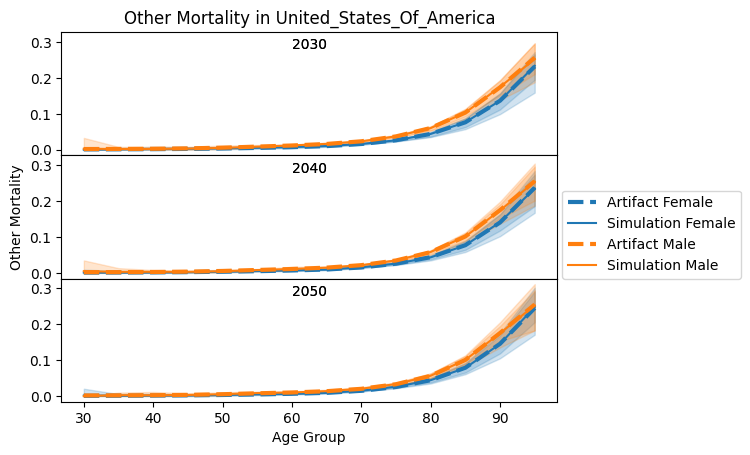

In [33]:
age_group_plot('Other Mortality', sim_ocmr, art_ocmr)

In [34]:
def over_time_plot(measure, sim_data, age_start):
    for location in sim_data.location.unique():
        for sex in sim_data.sex.unique():
            plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.age_start == age_start) & (sim_data.sex == sex)]

            plt.plot(plot_data.current_year, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.current_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.title(f"{measure} in {location} Over Time Among Age Start Group {age_start}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Year")
            plt.ylabel(f"{measure}")
            plt.legend()
        plt.figure()

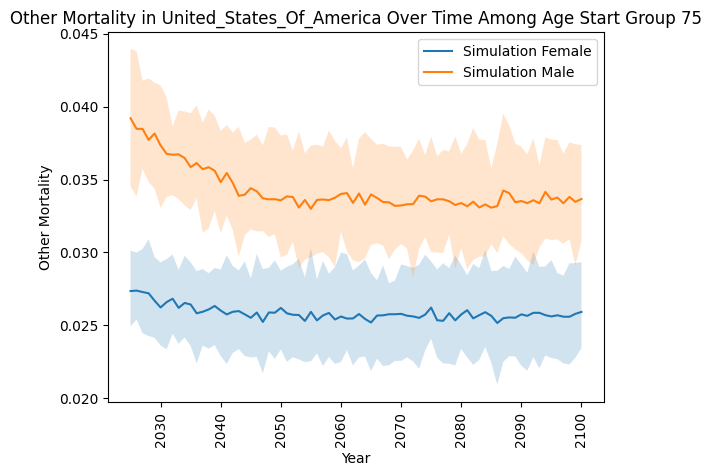

<Figure size 640x480 with 0 Axes>

In [35]:
over_time_plot('Other Mortality', sim_ocmr, 75)

## Validate Alzheimer’s EMR against GBD

In [36]:
cols = ['input_draw','current_year','location','age_group','sex']

def calculate_emr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    infected = person_time_total.loc[
        person_time_total.sub_entity == 'alzheimers_disease_state'
    ].groupby(cols).sum(numeric_only=True)
    assert len(infected) > 0

    deaths0 = load_df('deaths')
    deaths = deaths0.loc[
        deaths0.sub_entity == 'alzheimers_disease_state'
    ].groupby(cols).sum(numeric_only=True)
    assert len(deaths) > 0
    
    mr = (deaths / infected)[['value']].reset_index()

    mr = mr.merge(age_dictionary, on=['age_group'])
    mr = mr.loc[mr['age_group_id'].isin(age_group_ids)]
    mr1 = mr.groupby([c for c in cols if c != 'input_draw'] + ['age_start']
                    ).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return mr1

sim_emr = calculate_emr()

In [37]:
def load_artifact_cause_data(measure):
    out = pd.DataFrame()
    for artifact_dir in artifact_dirs:
        art = Artifact(artifact_dir, filter_terms = ['year_start==2021'])
        data = art.load(f'cause.alzheimers_disease_and_other_dementias.{measure}')
        data = (data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
                .filter(['mean', '2.5%', '97.5%']).reset_index())
        data = data.merge(age_dictionary, on=['age_start','age_end'])
        data = data.loc[data['age_group_id'].isin(age_group_ids)]
        data['measure'] = measure
        data['location'] = locations[artifact_dirs.index(artifact_dir)].title()
        out = pd.concat([out, data])
    return out

In [38]:
art_emr = load_artifact_cause_data('excess_mortality_rate')
# art_emr

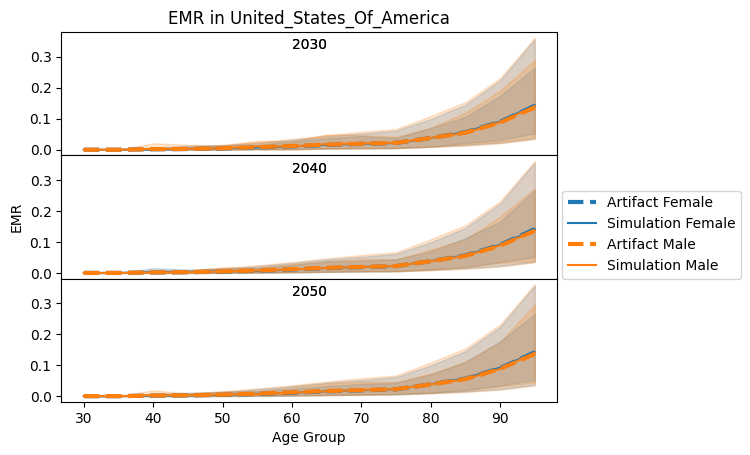

In [39]:
age_group_plot('EMR', sim_emr, art_emr, art_year=2021)

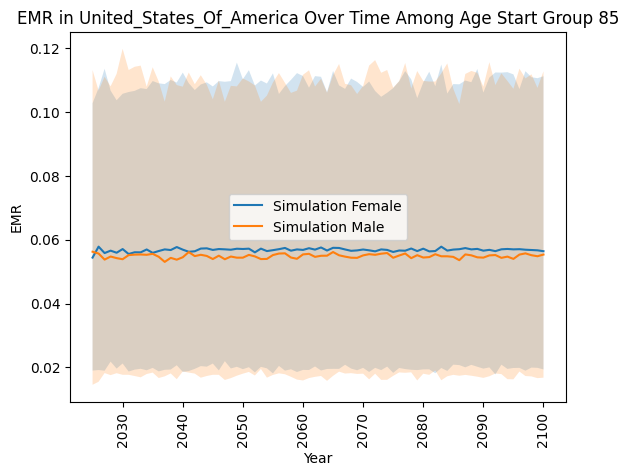

<Figure size 640x480 with 0 Axes>

In [40]:
over_time_plot('EMR', sim_emr, 85)

# Load population structure and initial all-state prevalence from Artifact

In [ ]:
# This is the number of people in each demographic group in each year --
# these numbers come from the FHS population forecasts
pop_structure = art.load('population.structure')
pop_structure

draw_0  \
location                 sex    age_start age_end year_start year_end                 
United States of America Female 5.0       10.0    2021       2022      9.732314e+06   
                                                  2022       2023      9.641272e+06   
                                                  2023       2024      9.548728e+06   
                                                  2024       2025      9.462539e+06   
                                                  2025       2026      9.394308e+06   
...                                                                             ...   
                         Male   95.0      125.0   2046       2047      4.776578e+05   
                                                  2047       2048      4.897427e+05   
                                                  2048       2049      5.022796e+05   
                                                  2049       2050      5.147342e+05   
                                                  2050       2051      5.262972e+05   

                                                                             draw_1  \
location                 sex    age_start age_end year_start year_end                 
United States of America Female 5.0       10.0    2021       2022      1.012986e+07   
                                                  2022       2023      1.003201e+07   
                                                  2023       2024      9.932675e+06   
                                                  2024       2025      9.841851e+06   
                                                  2025       2026      9.768750e+06   
...                                                                             ...   
                         Male   95.0      125.0   2046       2047      5.406595e+05   
                                                  2047       2048      5.562757e+05   
                                                  2048       2049      5.729534e+05   
                                                  2049       2050      5.894088e+05   
                                                  2050       2051      6.041910e+05   

                                                                             draw_2  \
location                 sex    age_start age_end year_start year_end                 
United States of America Female 5.0       10.0    2021       2022      9.854349e+06   
                                                  2022       2023      9.764145e+06   
                                                  2023       2024      9.672565e+06   
                                                  2024       2025      9.588970e+06   
                                                  2025       2026      9.524369e+06   
...                                                                             ...   
                         Male   95.0      125.0   2046       2047      5.049817e+05   
                                                  2047       2048      5.190315e+05   
                                                  2048       2049      5.336017e+05   
                                                  2049       2050      5.479230e+05   
                                                  2050       2051      5.613309e+05   

                                                                             draw_3  \
location                 sex    age_start age_end year_start year_end                 
United States of America Female 5.0       10.0    2021       2022      9.445721e+06   
                                                  2022       2023      9.357441e+06   
                                                  2023       2024      9.268302e+06   
                                                  2024       2025      9.186573e+06   
                                                  2025       2026      9.122883e+06   
...                                                                     

In [ ]:

# For each demographic group, the "population scaling factor" is the
# ratio of the real-world population in that group that we want to
# simulate to the total number of people in that group. For Model 4 and
# above, this equals the prevalence of all AD disease states combined
# (preclinical + MCI + AD-dementia), since we are modeling the
# population of people with any stage of AD.
art_all_states_initial_prev = art.load('population.scaling_factor')
art_all_states_initial_prev

draw_0    draw_1   draw_10  \
sex    age_start age_end year_start year_end                                 
Female 5.0       10.0    2021       2022      0.000000  0.000000  0.000000   
       10.0      15.0    2021       2022      0.000000  0.000000  0.000000   
       15.0      20.0    2021       2022      0.000000  0.000000  0.000000   
       20.0      25.0    2021       2022      0.000000  0.000000  0.000000   
       25.0      30.0    2021       2022      0.000000  0.000000  0.000000   
       30.0      35.0    2021       2022      0.001657  0.002043  0.001376   
       35.0      40.0    2021       2022      0.001657  0.002043  0.001376   
       40.0      45.0    2021       2022      0.001657  0.002043  0.001376   
       45.0      50.0    2021       2022      0.008375  0.006730  0.005621   
       50.0      55.0    2021       2022      0.013594  0.011801  0.012439   
       55.0      60.0    2021       2022      0.021537  0.020829  0.015861   
       60.0      65.0    2021       2022      0.034830  0.043608  0.037443   
       65.0      70.0    2021       2022      0.056649  0.075058  0.086136   
       70.0      75.0    2021       2022      0.131829  0.135718  0.132057   
       75.0      80.0    2021       2022      0.321953  0.316369  0.237907   
       80.0      85.0    2021       2022      0.558784  0.464064  0.528529   
       85.0      90.0    2021       2022      0.602467  0.623572  0.641937   
       90.0      95.0    2021       2022      0.534104  0.805182  0.753543   
       95.0      125.0   2021       2022      0.656396  0.800918  0.706042   
Male   5.0       10.0    2021       2022      0.000000  0.000000  0.000000   
       10.0      15.0    2021       2022      0.000000  0.000000  0.000000   
       15.0      20.0    2021       2022      0.000000  0.000000  0.000000   
       20.0      25.0    2021       2022      0.000000  0.000000  0.000000   
       25.0      30.0    2021       2022      0.000000  0.000000  0.000000   
       30.0      35.0    2021       2022      0.001506  0.001784  0.001076   
       35.0      40.0    2021       2022      0.001506  0.001784  0.001076   
       40.0      45.0    2021       2022      0.001506  0.001784  0.001076   
       45.0      50.0    2021       2022      0.007096  0.005748  0.004316   
       50.0      55.0    2021       2022      0.011100  0.009661  0.009969   
       55.0      60.0    2021       2022      0.017327  0.016287  0.012766   
       60.0      65.0    2021       2022      0.026870  0.032581  0.027170   
       65.0      70.0    2021       2022      0.041558  0.054861  0.059865   
       70.0      75.0    2021       2022      0.095525  0.100758  0.091688   
       75.0      80.0    2021       2022      0.239382  0.245659  0.173883   
       80.0      85.0    2021       2022      0.439605  0.378654  0.421474   
       85.0      90.0    2021       2022      0.517493  0.567205  0.557595   
       90.0      95.0    2021       2022      0.516097  0.792112  0.739027   
       95.0      125.0   2021       2022      0.692903  0.830496  0.705414   

                                              draw_100  draw_101  draw_102  \
sex    age_start age_end year_start year_end                                 
Female 5.0       10.0    2021       2022      0.000000  0.000000  0.000000   
       10.0      15.0    2021       2022      0.000000  0.000000  0.000000   
       15.0      20.0    2021       2022      0.000000  0.000000  0.000000   
       20.0      25.0    2021       2022      0.000000  0.000000  0.000000   
       25.0      30.0    2021       2022      0.000000  0.000000  0.000000   
       30.0      35.0    2021       2022      0.002648  0.001541  0.002004   
       35.0      40.0    2021       2022      0.002648  0.001541  0.002004   
       40.0      45.0    2021       2022      0.002648  0.001541  0.002004   
       45.0      50.0    2021       2022      0.006320  0.005286  0.006251   
       50.0      55.0    2021       2022      0.011123  0.010898  0.0

# Compute initial real-world all-state prevalence counts and model scale

In [ ]:
art_all_states_initial_prev_counts = pop_structure.query("year_start==2021") * art_all_states_initial_prev
art_all_states_initial_prev_counts.shape

(38, 500)

In [ ]:
# Ininitial simulated population per draw, from concept model
initial_sim_pop = 100_000
# Sum over age groups to get real-world population in each location
initial_real_world_pop = art_all_states_initial_prev_counts.groupby('location').sum()
# Model scale is the ratio of our simulated population to the real-world
# population at time 0
model_scale = initial_sim_pop / initial_real_world_pop
model_scale

,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,draw_106,...,draw_90,draw_91,draw_92,draw_93,draw_94,draw_95,draw_96,draw_97,draw_98,draw_99
location,,,,,,,,,,,,,,,,,,,,,
United States of America,0.007045,0.006462,0.007486,0.008582,0.007223,0.007292,0.00657,0.008038,0.007295,0.008144,...,0.007405,0.007756,0.008274,0.007381,0.008125,0.008789,0.007498,0.0077,0.008543,0.006712


In [95]:
model_scale.T.describe()

location,United States of America
count,500.000000
mean,0.007563
std,0.000631
min,0.005796
25%,0.007133
50%,0.007509
75%,0.007977
max,0.010579


In [ ]:
# Old version
scale = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    temp = art.load('population.structure').reset_index() 
    temp['location'] = temp.location.str.replace(' ', '_').str.title()
    
    df_prev_pop = pd.merge(
        art.load('population.scaling_factor').query("year_start == 2021"),
        art.load('population.structure').query("year_start==2025").droplevel(['year_start', 'year_end']),
        left_index=True,
        right_index=True,
        suffixes=['_prev', '_pop']
    )
    prev = ((df_prev_pop.filter(like='draw_').filter(like='_prev')
            * df_prev_pop.filter(like='draw_').filter(like='_pop').values).mean(axis=1)).sum(axis=0)
    # TODO: use draw-specific scale instead of mean

    ratio = 100_000 / prev
    temp['ratio'] = ratio

    temp = temp.rename(columns={'year_start': 'current_year'})
    temp = temp.merge(age_dictionary, on=['age_start','age_end'])
    temp = temp.loc[temp['age_group_id'].isin(age_group_ids)]
    scale = pd.concat([scale, temp], ignore_index=True)
# scale

In [76]:
ratio

0.006722348558006507

In [77]:
scale.ratio.unique()

array([0.00672235])

In [43]:
scale.groupby('location').ratio.describe()/5  # compare to 0.0035494897066482814 in interactive sim for USA

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
United_States_Of_America,168.0,0.001344,0.0,0.001344,0.001344,0.001344,0.001344,0.001344


## Verify the number of new simulants per year against the AD population model

In [ ]:
# # Alternative version:
# art_incidence_rate = art.load(
#     'cause.alzheimers_disease_and_other_dementias.population_incidence_rate'
# )
# art_incidence_counts = (
#     art_incidence_rate.droplevel(['year_start', 'year_end'])
#     * pop_structure
# )
# art_incidence_data = art_incidence_counts

art_incidence_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            'cause.alzheimers_disease_and_other_dementias.population_incidence_rate'
        ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    art_incidence_data.append(df)
    
art_incidence_data = pd.concat(art_incidence_data)
for i in range(500):
    art_incidence_data[f'draw_{i}'] *= art_incidence_data[f'draw_{i}_pop']
    del art_incidence_data[f'draw_{i}_pop']
    

In [107]:
cols = ['input_draw','current_year','location','age_group','sex']

new_sims = load_df('new_simulants')
new_sims

,age_group,current_year,sex,scenario,input_draw,value,location
0,25_to_29,2025,Female,baseline,2,1.0,United_States_Of_America
1,25_to_29,2025,Female,baseline,13,0.0,United_States_Of_America
2,25_to_29,2025,Female,baseline,24,0.0,United_States_Of_America
3,25_to_29,2025,Female,baseline,41,0.0,United_States_Of_America
4,25_to_29,2025,Female,baseline,46,0.0,United_States_Of_America
...,...,...,...,...,...,...,...
56995,95_plus,2100,Male,baseline,446,0.0,United_States_Of_America
56996,95_plus,2100,Male,baseline,457,0.0,United_States_Of_America
56997,95_plus,2100,Male,baseline,460,0.0,United_States_Of_America
56998,95_plus,2100,Male,baseline,480,0.0,United_States_Of_America


In [108]:
trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
new_ad_dementia = trans[trans.sub_entity == 'alzheimers_mild_cognitive_impairment_state_to_alzheimers_disease_state']

In [109]:
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio','current_year']])
new_ad_dementia = new_ad_dementia.merge(scale[['location','sex','age_group','ratio','current_year']])

In [110]:
# new_sims

In [111]:
new_sims['total_incidence'] = new_sims['value'] / new_sims['ratio']
new_ad_dementia['total_incidence'] = new_ad_dementia['value'] / new_sims['ratio']

def summarize(df):
    df = df.groupby(cols).sum(numeric_only=True)
    df = df.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_incidence'].reset_index()

    df = df.merge(age_dictionary, on=['age_group'])
    df = df.loc[df['age_group_id'].isin(age_group_ids)]

    return df

new_sims_summary = summarize(new_sims)

In [112]:
new_ad_dementia_summary = summarize(new_ad_dementia)
new_ad_dementia_summary

,current_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
0,2025,United_States_Of_America,30_to_34,Female,25.0,1927.897652,826.553052,297.515070,654.533153,1933.847953,3629.683851,4611.483581,11,30 to 34,30.0,35.0
1,2025,United_States_Of_America,30_to_34,Male,25.0,1505.426253,793.358024,297.515070,476.024112,1338.817814,3213.162753,3570.180837,11,30 to 34,30.0,35.0
2,2026,United_States_Of_America,30_to_34,Female,25.0,1213.861485,572.410541,148.757535,238.012056,1190.060279,2469.375079,2826.393162,11,30 to 34,30.0,35.0
3,2026,United_States_Of_America,30_to_34,Male,25.0,987.750032,507.885907,297.515070,386.769591,892.545209,2142.108502,2231.363023,11,30 to 34,30.0,35.0
4,2027,United_States_Of_America,30_to_34,Female,25.0,809.240990,468.605911,0.000000,89.254521,595.030139,1547.078363,1636.332884,11,30 to 34,30.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,2048,United_States_Of_America,95_plus,Male,25.0,12180.266955,2408.356465,8479.179487,8479.179487,12049.360324,17434.383086,18148.419254,33,95 to 99,95.0,125.0
724,2049,United_States_Of_America,95_plus,Female,25.0,20820.104580,3351.856412,13536.935673,14518.735403,21123.569951,26746.604769,28710.204229,33,95 to 99,95.0,125.0
725,2049,United_States_Of_America,95_plus,Male,25.0,12674.141971,2373.914236,8330.421953,8687.440036,12198.117859,17107.116510,17553.389114,33,95 to 99,95.0,125.0
726,2050,United_States_Of_America,95_plus,Female,25.0,21093.818444,4615.480707,13536.935673,14250.971840,20677.297346,30168.028071,30346.537113,33,95 to 99,95.0,125.0


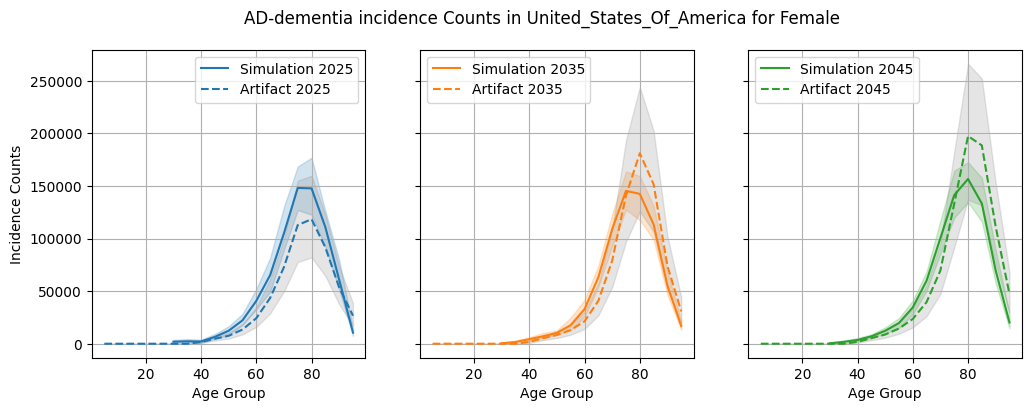

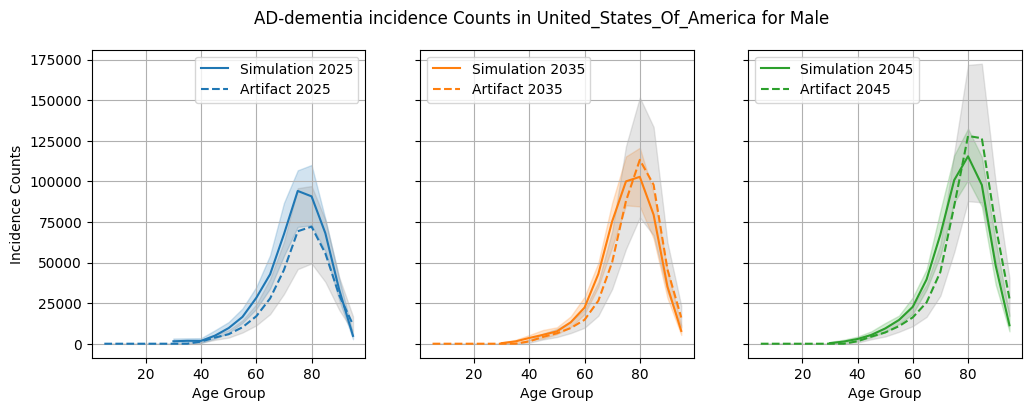

In [128]:
for location in new_sims.location.unique():
    for sex in new_sims.sex.unique():
        fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(12,4))
        plt.subplots_adjust(hspace=0)
        for i, year in enumerate([2025, 2035, 2045]):
            color = f'C{i}'
            plot_data = new_ad_dementia_summary.query('location == @location and current_year == @year and sex == @sex')

            location_w_spaces = location.replace('_', ' ').replace('Of', 'of')
            art_plot = art_incidence_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()

            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            ax[i].fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2, color=color)
            ax[i].fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2, color='grey')
            ax[i].plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {year}', color=color)
            ax[i].plot(art_plot.age_start, art_plot['mean'], label=f'Artifact {year}', color=color, linestyle='--')
            ax[i].grid(True)
            if i == 0:
                ax[i].set_ylabel(f"Incidence Counts")
            #     ax[i].set_title(f"AD-dementia incidence Counts in {location} for {sex}")
#             plt.tick_params(axis='x', labelrotation=90)
            ax[i].set_xlabel("Age Group")
            # if i == 1:
            #     ax[i].set_ylabel(f"Incidence Counts")
            ax[i].legend()#.legend(loc=(1.01, 0))
        fig.suptitle(f"AD-dementia incidence Counts in {location} for {sex}")


## Verifying Prevalence of all states combined

In [ ]:
# # Alternative version:
# art_all_states_prev_counts = (
#     art_all_states_initial_prev.droplevel(['year_start', 'year_end'])
#     * pop_structure
# )
# art_prev_data = art_all_states_prev_counts

art_prev_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            'population.scaling_factor'
                ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    art_prev_data.append(df)
    
art_prev_data = pd.concat(art_prev_data)
for i in range(500):
    art_prev_data[f'draw_{i}'] *= art_prev_data[f'draw_{i}_pop']
    del art_prev_data[f'draw_{i}_pop']
art_prev_data

draw_0  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                                                                              ...   
Male   95.0      125.0   United States of America 2046       2047      330970.674824   
                                                  2047       2048      339344.336022   
                                                  2048       2049      348031.186506   
                                                  2049       2050      356661.049969   
                                                  2050       2051      364673.050677   

                                                                              draw_1  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                                                                              ...   
Male   95.0      125.0   United States of America 2046       2047      449015.564938   
                                                  2047       2048      461984.782189   
                                                  2048       2049      475835.555209   
                                                  2049       2050      489501.717735   
                                                  2050       2051      501778.237165   

                                                                             draw_10  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                                                                              ...   
Male   95.0      125.0   United States of America 2046       2047      386755.658043   
                                                  2047       2048      401341.115741   
                                                  2048       2049      416637.287801   
                                                  2049       2050      431925.602486   
                                                  2050       2051      446511.536350   

                                                                            draw_100  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                        

In [72]:
cols = ['input_draw','current_year','location','age_group','sex']

new_sims = load_df('person_time_alzheimers_disease_and_other_dementias')
new_sims

,measure,entity_type,entity,sub_entity,age_group,current_year,sex,scenario,input_draw,value,location
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,baseline,2,0.000000,United_States_Of_America
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,baseline,13,0.000000,United_States_Of_America
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,baseline,24,0.000000,United_States_Of_America
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,baseline,41,0.000000,United_States_Of_America
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,baseline,46,0.000000,United_States_Of_America
...,...,...,...,...,...,...,...,...,...,...,...
170995,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2100,Male,baseline,446,319.655031,United_States_Of_America
170996,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2100,Male,baseline,457,293.100616,United_States_Of_America
170997,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2100,Male,baseline,460,402.324435,United_States_Of_America
170998,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2100,Male,baseline,480,314.644764,United_States_Of_America


In [74]:
scale

,location,sex,age_start,age_end,current_year,year_end,draw_0,draw_1,draw_2,draw_3,...,draw_494,draw_495,draw_496,draw_497,draw_498,draw_499,ratio,age_group_id,age_group_name,age_group
0,United_States_Of_America,Female,30.0,35.0,2021,2022,1.155513e+07,1.202714e+07,1.170002e+07,1.121486e+07,...,1.125542e+07,1.167054e+07,1.201985e+07,1.137727e+07,1.084559e+07,1.123404e+07,0.006722,11,30 to 34,30_to_34
1,United_States_Of_America,Female,30.0,35.0,2022,2023,1.157185e+07,1.204003e+07,1.172012e+07,1.123139e+07,...,1.127718e+07,1.168870e+07,1.203246e+07,1.139530e+07,1.086539e+07,1.125544e+07,0.006722,11,30 to 34,30_to_34
2,United_States_Of_America,Female,30.0,35.0,2023,2024,1.155799e+07,1.202068e+07,1.170977e+07,1.121918e+07,...,1.126763e+07,1.167535e+07,1.201230e+07,1.138381e+07,1.085858e+07,1.124764e+07,0.006722,11,30 to 34,30_to_34
3,United_States_Of_America,Female,30.0,35.0,2024,2025,1.152694e+07,1.198565e+07,1.168434e+07,1.119215e+07,...,1.124366e+07,1.164489e+07,1.197490e+07,1.135707e+07,1.083734e+07,1.122622e+07,0.006722,11,30 to 34,30_to_34
4,United_States_Of_America,Female,30.0,35.0,2025,2026,1.149575e+07,1.194940e+07,1.166062e+07,1.116640e+07,...,1.122054e+07,1.161536e+07,1.193850e+07,1.133165e+07,1.081614e+07,1.120671e+07,0.006722,11,30 to 34,30_to_34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,United_States_Of_America,Male,95.0,125.0,2046,2047,4.776578e+05,5.406595e+05,5.049817e+05,5.222527e+05,...,4.985853e+05,5.227748e+05,5.281299e+05,6.701626e+05,5.409489e+05,5.437706e+05,0.006722,33,95 to 99,95_plus
836,United_States_Of_America,Male,95.0,125.0,2047,2048,4.897427e+05,5.562757e+05,5.190315e+05,5.397755e+05,...,5.133524e+05,5.386952e+05,5.446530e+05,6.986519e+05,5.599898e+05,5.617033e+05,0.006722,33,95 to 99,95_plus
837,United_States_Of_America,Male,95.0,125.0,2048,2049,5.022796e+05,5.729534e+05,5.336017e+05,5.583712e+05,...,5.284282e+05,5.547403e+05,5.616294e+05,7.281752e+05,5.794990e+05,5.800382e+05,0.006722,33,95 to 99,95_plus
838,United_States_Of_America,Male,95.0,125.0,2049,2050,5.147342e+05,5.894088e+05,5.479230e+05,5.767340e+05,...,5.431262e+05,5.703575e+05,5.778054e+05,7.574645e+05,5.992580e+05,5.981090e+05,0.006722,33,95 to 99,95_plus


In [73]:

new_sims = new_sims.merge(scale[['location','sex','age_group','ratio','current_year']])
# new_sims['total_prev'] = new_sims['value'] / new_sims['ratio']
# new_sims = new_sims.groupby(cols).sum(numeric_only=True)
# new_sims = new_sims.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_prev'].reset_index()

# new_sims = new_sims.merge(age_dictionary, on=['age_group'])
# new_sims = new_sims.loc[new_sims['age_group_id'].isin(age_group_ids)]
new_sims.tail()

,measure,entity_type,entity,sub_entity,age_group,current_year,sex,scenario,input_draw,value,location,ratio
54595,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2050,Male,baseline,446,297.609856,United_States_Of_America,0.006722
54596,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2050,Male,baseline,457,270.053388,United_States_Of_America,0.006722
54597,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2050,Male,baseline,460,327.170431,United_States_Of_America,0.006722
54598,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2050,Male,baseline,480,284.082136,United_States_Of_America,0.006722
54599,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2050,Male,baseline,499,444.410678,United_States_Of_America,0.006722


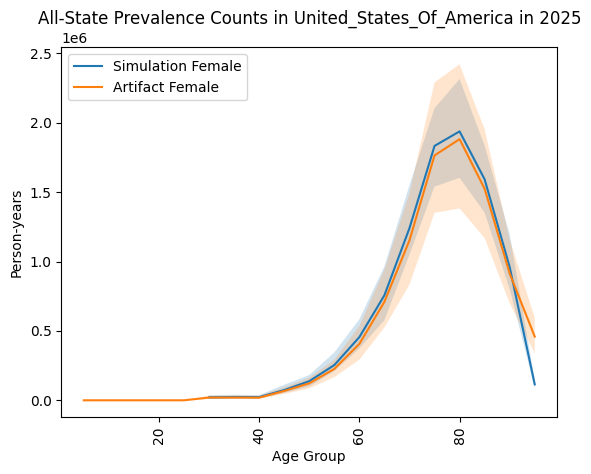

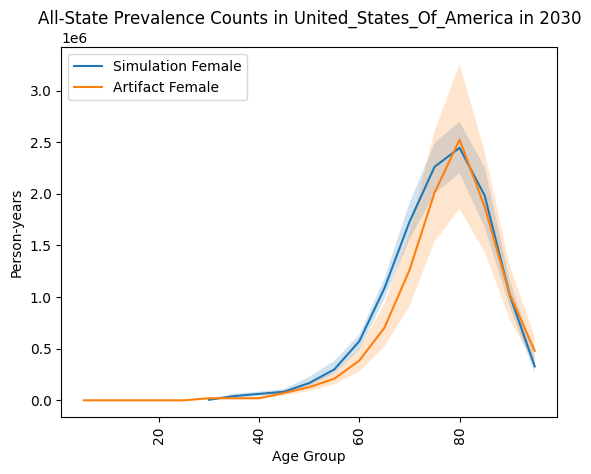

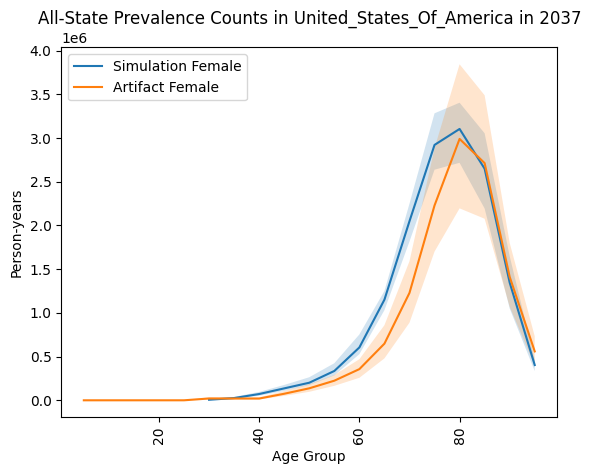

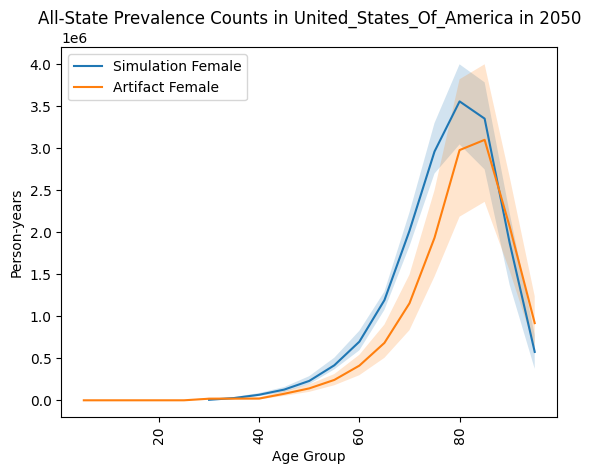

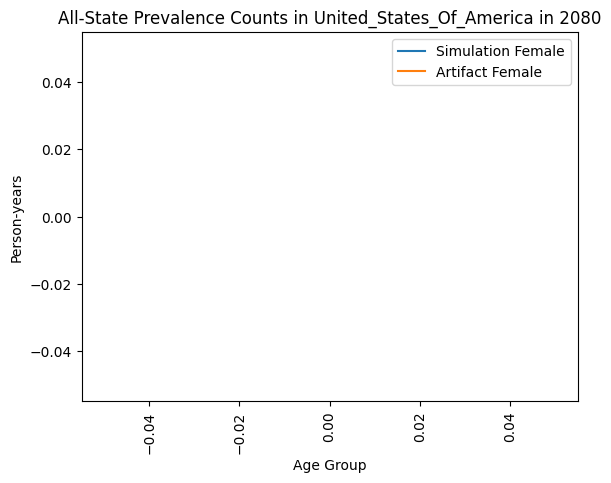

<Figure size 640x480 with 0 Axes>

In [70]:
for location in new_sims.location.unique():
    for year in [2025, 2030, 2037, 2050, 2080]:
        for sex in new_sims.sex.unique()[:1]:
            plot_data = new_sims.loc[(new_sims.location == location) & (new_sims.current_year == year) & (new_sims.sex == sex) ]
#             gbd_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'prevalence')]

            location_w_spaces = location.replace('_', ' ').replace('Of', 'of')
            art_plot = art_prev_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()
            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.plot(art_plot.age_start, art_plot['mean'], label=f'Artifact {sex}')
            plt.fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2)

            plt.title(f"All-State Prevalence Counts in {location} in {year}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Person-years")
            plt.legend()
        plt.figure()

In [71]:
plot_data

,current_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end


## Verifying Prevalence of AD dementia

In [60]:
art.keys

['metadata.keyspace',
 'metadata.locations',
 'population.location',
 'population.structure',
 'population.age_bins',
 'population.demographic_dimensions',
 'population.theoretical_minimum_risk_life_expectancy',
 'cause.all_causes.cause_specific_mortality_rate',
 'covariate.live_births_by_sex.estimate',
 'population.scaling_factor',
 'cause.alzheimers_disease_and_other_dementias.prevalence',
 'cause.alzheimers.bbbm_conditional_prevalence',
 'cause.alzheimers.mci_conditional_prevalence',
 'cause.alzheimers_disease_and_other_dementias.incidence_rate',
 'cause.alzheimers.mci_to_dementia_transition_rate',
 'cause.alzheimers.susceptible_to_bbbm_transition_count',
 'cause.alzheimers_disease_and_other_dementias.population_incidence_rate',
 'cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate',
 'cause.alzheimers_disease_and_other_dementias.excess_mortality_rate',
 'cause.alzheimers_disease_and_other_dementias.disability_weight',
 'cause.alzheimers.mci_disability_weight'

In [61]:
art_prev_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            'cause.alzheimers_disease_and_other_dementias.prevalence'
                ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    art_prev_data.append(df)
    
art_prev_data = pd.concat(art_prev_data)
for i in range(500):
    art_prev_data[f'draw_{i}'] *= art_prev_data[f'draw_{i}_pop']
    del art_prev_data[f'draw_{i}_pop']
art_prev_data

draw_0  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                                                                              ...   
Male   95.0      125.0   United States of America 2046       2047      113117.900286   
                                                  2047       2048      115979.818409   
                                                  2048       2049      118948.777177   
                                                  2049       2050      121898.259137   
                                                  2050       2051      124636.570311   

                                                                              draw_1  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                                                                              ...   
Male   95.0      125.0   United States of America 2046       2047      190107.389801   
                                                  2047       2048      195598.388849   
                                                  2048       2049      201462.627221   
                                                  2049       2050      207248.703894   
                                                  2050       2051      212446.423632   

                                                                              draw_2  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                                                                              ...   
Male   95.0      125.0   United States of America 2046       2047      182443.992199   
                                                  2047       2048      187520.007330   
                                                  2048       2049      192784.070644   
                                                  2049       2050      197958.180186   
                                                  2050       2051      202802.322653   

                                                                              draw_3  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                        

In [64]:
cols = ['input_draw','current_year','location','age_group','sex']

new_sims = load_df('person_time_alzheimers_disease_and_other_dementias')
new_sims = new_sims.loc[new_sims.sub_entity == 'alzheimers_disease_state']
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio','current_year']])
new_sims['total_prev'] = new_sims['value'] / new_sims['ratio']
new_sims = new_sims.groupby(cols).sum(numeric_only=True)
new_sims = new_sims.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_prev'].reset_index()

new_sims = new_sims.merge(age_dictionary, on=['age_group'])
new_sims = new_sims.loc[new_sims['age_group_id'].isin(age_group_ids)]
new_sims.tail()

,current_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
723,2048,United_States_Of_America,95_plus,Male,25.0,188534.872050,64553.856547,84593.247856,92866.243902,185508.893316,303507.157638,307442.420622,33,95 to 99,95.0,125.0
724,2049,United_States_Of_America,95_plus,Female,25.0,358621.708232,120322.195428,164416.479974,169469.715396,378769.062206,542827.790999,581420.199581,33,95 to 99,95.0,125.0
725,2049,United_States_Of_America,95_plus,Male,25.0,193853.439598,67237.511617,83996.995889,95087.282480,190204.377558,313717.972577,314522.912733,33,95 to 99,95.0,125.0
726,2050,United_States_Of_America,95_plus,Female,25.0,366435.590263,122913.606026,163894.759502,173911.792552,391141.290527,554126.765779,598711.506631,33,95 to 99,95.0,125.0
727,2050,United_States_Of_America,95_plus,Male,25.0,199371.751555,70346.490326,81761.051011,95042.563582,199595.346042,323377.254447,327267.798533,33,95 to 99,95.0,125.0


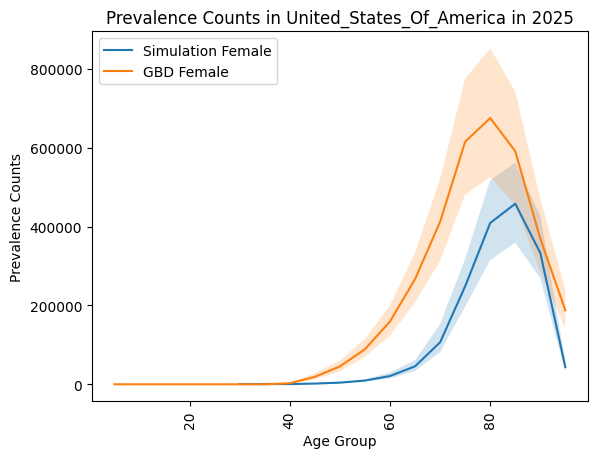

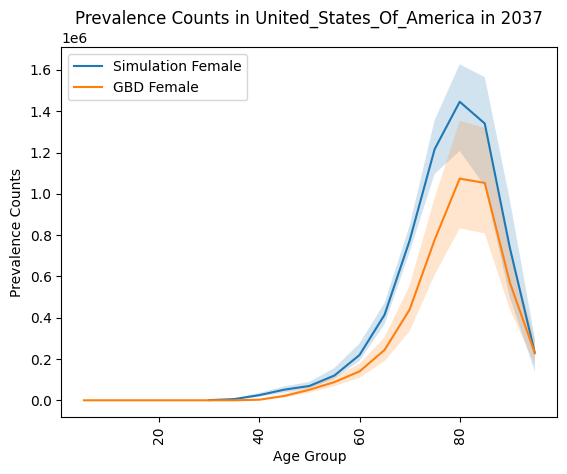

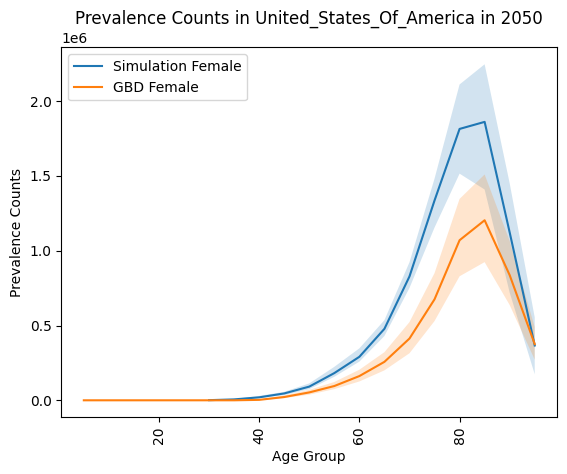

<Figure size 640x480 with 0 Axes>

In [ ]:
for location in new_sims.location.unique():
    for year in [2025,2037,2050]:
        for sex in new_sims.sex.unique()[:1]:
            plot_data = new_sims.loc[(new_sims.location == location) & (new_sims.current_year == year) & (new_sims.sex == sex) ]
#             gbd_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'prevalence')]

            location_w_spaces = location.replace('_', ' ').replace('Of', 'of')
            art_plot = art_prev_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()
            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.plot(art_plot.age_start, art_plot['mean'], label=f'GBD {sex}')
            plt.fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2)

            plt.title(f"AD-dementia Prevalence Counts in {location} in {year}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Person-years")
            plt.legend()
        plt.figure()

## Total Sim Population Over Time

In [54]:
cols = ['input_draw','current_year','location'] #, 'age_group']

person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time_total = person_time_total.groupby(cols)['value'].sum().reset_index()
person_time_total = person_time_total.groupby([c for c in cols if c != 'input_draw'])['value'].describe(percentiles=[0.025,0.975]).reset_index()
person_time_total#.head()

,current_year,location,count,mean,std,min,2.5%,50%,97.5%,max
0,2025,United_States_Of_America,25.0,101911.595236,149.295034,101610.217659,101613.223819,101935.885010,102105.232033,102121.765914
1,2026,United_States_Of_America,25.0,108650.284025,668.017104,107360.000000,107470.025462,108848.049281,109662.818891,109746.390144
2,2027,United_States_Of_America,25.0,115093.607556,1233.362932,112693.930185,112886.925667,115511.203285,116728.397536,116748.238193
3,2028,United_States_Of_America,25.0,121359.307105,1863.413264,117649.585216,117914.427926,121810.611910,123842.074743,123855.301848
4,2029,United_States_Of_America,25.0,127440.729035,2464.022406,122655.843943,122899.643532,128285.379877,130583.589322,130917.273101
...,...,...,...,...,...,...,...,...,...,...
71,2096,United_States_Of_America,25.0,197335.275565,13825.311942,173900.353183,176334.741684,201939.811088,213750.413142,215856.829569
72,2097,United_States_Of_America,25.0,197316.196468,13836.194306,173815.178645,176322.015606,201789.503080,213642.692402,215722.053388
73,2098,United_States_Of_America,25.0,197323.511458,13914.892799,173607.753593,176132.627515,201842.110883,213776.366324,215935.991786
74,2099,United_States_Of_America,25.0,197294.031047,13908.655390,173505.043121,176018.794251,201872.673511,213748.308830,215936.492813


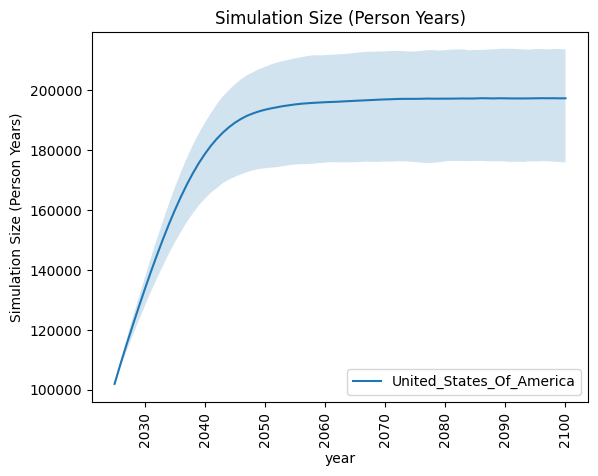

In [55]:
for location in person_time_total.location.unique():
    plot_data = person_time_total.loc[(person_time_total.location == location)]
    plt.plot(plot_data.current_year, plot_data['mean'], label=location)
    plt.fill_between(plot_data.current_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)
    plt.title(f"Simulation Size (Person Years)")
    plt.tick_params(axis='x', labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()